# Lung Disease Classifier Using Convolutional Neural Networks

## Overview

This project focuses on building a robust lung disease classifier using Convolutional Neural Networks (CNNs). The classifier is designed to analyze X-ray images and distinguish between three categories:
- **COVID-19**
- **Pneumonia**
- **Normal Lungs**

The goal of this project is to develop a model that can accurately classify these lung conditions based on the provided X-ray images, aiding in the diagnosis of respiratory diseases.

## Problem Statement

Early and accurate diagnosis of lung diseases such as COVID-19 and pneumonia is critical for effective treatment and patient outcomes. However, diagnosing these conditions using X-ray images can be challenging, especially in regions with limited access to experienced radiologists. The problem this project aims to solve is how to leverage deep learning to create an automated tool that can assist healthcare workers in making quick and reliable diagnoses based on X-ray images.

## Impact on Healthcare

This CNN-based model can be used to support healthcare workers by:
- **Reducing Diagnostic Time**: Automating the classification of lung diseases to speed up the diagnostic process.
- **Supporting Decision Making**: Providing an additional tool that healthcare professionals can use to confirm or complement their diagnoses.
- **Expanding Access**: Helping in areas with limited access to radiologists by providing a reliable first-pass analysis of X-ray images.

## Dataset

The dataset used in this project was obtained from the COVID-19 Radiography Database on Kaggle. The data consists of labeled X-ray images, and image masks categorized into three classes: COVID-19, Pneumonia, and Normal. Each image is preprocessed and augmented to enhance the model's generalization ability.

## Model Architecture

The CNN model is designed with multiple convolutional layers, max-pooling layers, and fully connected layers. The model is trained using a combination of data augmentation techniques to prevent overfitting and improve accuracy.

## Objectives

- **Image Classification**: Accurately classify X-ray images into the correct category (COVID-19, Pneumonia, or Normal).
- **Model Optimization**: Implement techniques such as early stopping, data augmentation, and learning rate adjustments to optimize the model's performance.
- **Evaluation**: Assess the model's performance using various metrics such as accuracy, loss, and confusion matrix.

## Tools and Libraries

- **TensorFlow/Keras**: For building and training the CNN model.
- **ImageDataGenerator**: For data augmentation.
- **Matplotlib/Seaborn**: For visualizing the model's performance.
- **Scikit-learn**: For additional evaluation metrics and model validation.

# Imports

In [264]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout, AveragePooling2D, Input

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# Tensorflow GPU setup
#### Shows available GPU's for training acceleration. If no devices are found, the CPU will be used by default

In [265]:
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)

else:
    print("Failed to detect a GPU.")


Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# Tensor Functions


- Load images
- Convert to greyscale
- Ensure 256x256, and .jpg/.png/.jpeg
- Convert to tensor
- Apply mask
- Return tensor dataframe

In [266]:
def convert_to_grayscale_tensor(folder_path, num_images=2000, target_size=(256, 256)):
    image_tensors = []
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    for image_file in image_files[:num_images]:
        image_path = os.path.join(folder_path, image_file)
        image = load_img(image_path, color_mode='grayscale', target_size=target_size)  # Load as grayscale
        image_array = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
        image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
        image_tensors.append(image_tensor.numpy().flatten())  # Flatten the tensor
    
    return image_tensors

#### Multiply the mask pixel values by the X-ray image pixel values. This will reduce any noise that is not within the lungs.

In [267]:
def apply_masks_to_tensors(image_folder, mask_folder, num_images=2000, target_size=(256, 256)):
    # Get all image files and convert them to grayscale tensors
    image_tensors = convert_to_grayscale_tensor(image_folder, None, target_size)
    mask_files = [f for f in os.listdir(mask_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Sort masks to match images, assuming names are identical
    mask_files.sort()
    
    # Handle oversampling or downsampling
    num_available_images = len(image_tensors)
    if num_available_images > num_images:
        selected_indices = np.random.choice(num_available_images, num_images, replace=False)
    else:
        selected_indices = np.random.choice(num_available_images, num_images, replace=True)

    selected_image_tensors = [image_tensors[i] for i in selected_indices]
    selected_mask_files = [mask_files[i] for i in selected_indices]

    masked_tensors = []
    print("Applying mask:", mask_folder)
    for i, tensor in enumerate(selected_image_tensors):
        mask_file = selected_mask_files[i]
        mask_path = os.path.join(mask_folder, mask_file)
        mask_image = load_img(mask_path, color_mode='grayscale', target_size=target_size)
        mask_array = img_to_array(mask_image) / 255.0  # Normalize pixel values to [0, 1]


        
        mask_tensor = tf.convert_to_tensor(mask_array, dtype=tf.float32) # Can change to 16

        
        
        # Apply mask: element-wise multiplication
        masked_array = tensor.reshape(target_size[0], target_size[1]) * mask_tensor.numpy().reshape(target_size[0], target_size[1])
        
        # Flatten and append
        masked_tensors.append(masked_array.flatten())
    
    return masked_tensors

## Create dataframe / Load dataframe

In [268]:
use_df = True  # Use saved dataframe, will create a new one if True and none found

# Define paths
pkl_file_path = 'Image_df/dataframe.pkl'
base_folder = 'Images'

if use_df:
    if os.path.exists(pkl_file_path):
        print("Loading DataFrame from existing file.")
        try:
            # Load the DataFrame from the .pkl file
            df = pd.read_pickle(pkl_file_path)
            print(f"DataFrame loaded from {pkl_file_path}")
        except Exception as e:
            print(f"Error loading DataFrame: {e}")
            # Proceed to create the DataFrame if loading fails
            use_df = False
    else:
        print("No saved DataFrame found. Proceeding to create a new DataFrame.")
        use_df = False

if not use_df:
    # Create the DataFrame if it does not exist
    folders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]

    # Dictionary to hold DataFrames for each folder
    dataframes = {}

    # Process each folder
    for folder_name in folders:
        image_folder_path = os.path.join(base_folder, folder_name, 'images')
        mask_folder_path = os.path.join(base_folder, folder_name, 'masks')
        
        print(f"Processing folder: {image_folder_path}")  # Debug: print current folder being processed
        
        # Apply masks to images in the folder
        tensors = apply_masks_to_tensors(image_folder_path, mask_folder_path)
        
        # Check if tensors are empty
        if not tensors:
            print(f"No tensors created for folder: {image_folder_path}")
            continue
        
        # Create a DataFrame from the tensors
        df = pd.DataFrame(tensors)
        
        # Add a column for the folder name as the label
        df['Label'] = folder_name.lower()  # e.g., 'covid', 'pneumonia', etc.
        
        # Store the DataFrame in the dictionary
        dataframes[folder_name] = df

    # Concatenate all DataFrames into a single DataFrame if needed
    df = pd.concat(dataframes.values(), ignore_index=True)
    print("Processing complete.")

    # Save the DataFrame as a .pkl file
    os.makedirs('Image_df', exist_ok=True)  # Create the folder if it doesn't exist

    try:
        df.to_pickle(pkl_file_path)
        print(f"DataFrame saved to {pkl_file_path}")
    except Exception as e:
        print(f"Error saving DataFrame: {e}")



Loading DataFrame from existing file.
DataFrame loaded from Image_df/dataframe.pkl


In [269]:
df

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,covid
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,covid
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,covid
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,covid
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,viral_pneumonia
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,viral_pneumonia
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,viral_pneumonia
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,viral_pneumonia


In [270]:
# Split data into features and labels
X = df.drop('Label', axis=1).values
y = df['Label'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.4, random_state=42)

# Evaluation Function
#### Print classification report, ROC AUC curves, confusion matricies, accuracy and loss plots.

In [271]:
def metrics(model, X_test, y_test, label_encoder, history_dict, model_name):
    
    
    # Make predictions
    y_pred_proba = model.predict(X_test)  # Predict probabilities for ROC
    y_pred_classes = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class labels

    # Plot loss values over epochs
    train_loss = history_dict.get('loss', [])
    val_loss = history_dict.get('val_loss', [])  # Validation loss might not be available

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    if val_loss:
        plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Values Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'Charts/{model_name}_Loss.png')  # Save before showing
    plt.show()
    
    # Training and Validation Accuracy
    train_accuracy = history_dict.get('accuracy', [])
    val_accuracy = history_dict.get('val_accuracy', [])  # Validation accuracy might not be available

    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracy, label='Training Accuracy')
    if val_accuracy:
        plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'Charts/{model_name}_Accuracy.png')  # Save before showing
    plt.show()
    
    # Compute Test Accuracy
    test_accuracy = accuracy_score(y_test, y_pred_classes)

    # Print Final Accuracies
    if train_accuracy:
        print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
    if val_accuracy:
        print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")
    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes, labels=np.arange(len(label_encoder.classes_)))
    plt.figure(figsize=(12, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.tight_layout(pad=2.0) 
    plt.savefig(f'Charts/{model_name}_Confusion.png')  # Save before showing
    plt.show()
    
    # ROC Curve
    y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
    fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
    roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average='macro')
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(f'Charts/{model_name}_ROC.png')  # Save before showing
    plt.show()
    
    # Classification Report
    report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
    print("Classification Report:\n", report)
    

# Baseline Model
- Sequential, 3 layers
- No data augmentation

In [272]:
use_saved_model = True # Set to Flase if changing paramaters

Epoch 1/30
180/180 [==============================] - 2s 8ms/step - loss: 3.4977 - accuracy: 0.4250 - val_loss: 0.8243 - val_accuracy: 0.6264
Epoch 2/30
180/180 [==============================] - 1s 7ms/step - loss: 0.9847 - accuracy: 0.5469 - val_loss: 0.7415 - val_accuracy: 0.6333
Epoch 3/30
180/180 [==============================] - 1s 7ms/step - loss: 0.8696 - accuracy: 0.5944 - val_loss: 0.7568 - val_accuracy: 0.6514
Epoch 4/30
180/180 [==============================] - 1s 7ms/step - loss: 0.8595 - accuracy: 0.5670 - val_loss: 0.7737 - val_accuracy: 0.6625
Epoch 5/30
180/180 [==============================] - 1s 7ms/step - loss: 0.7855 - accuracy: 0.6156 - val_loss: 0.6872 - val_accuracy: 0.7000
Epoch 6/30
180/180 [==============================] - 1s 7ms/step - loss: 0.7656 - accuracy: 0.6302 - val_loss: 0.6218 - val_accuracy: 0.6792
Epoch 7/30
180/180 [==============================] - 1s 7ms/step - loss: 0.7152 - accuracy: 0.6521 - val_loss: 0.6102 - val_accuracy: 0.7181
Epoch 

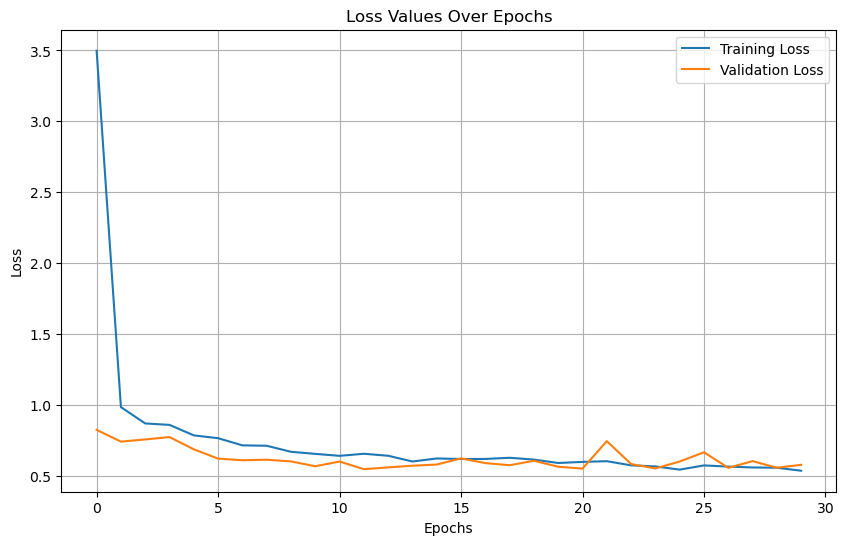

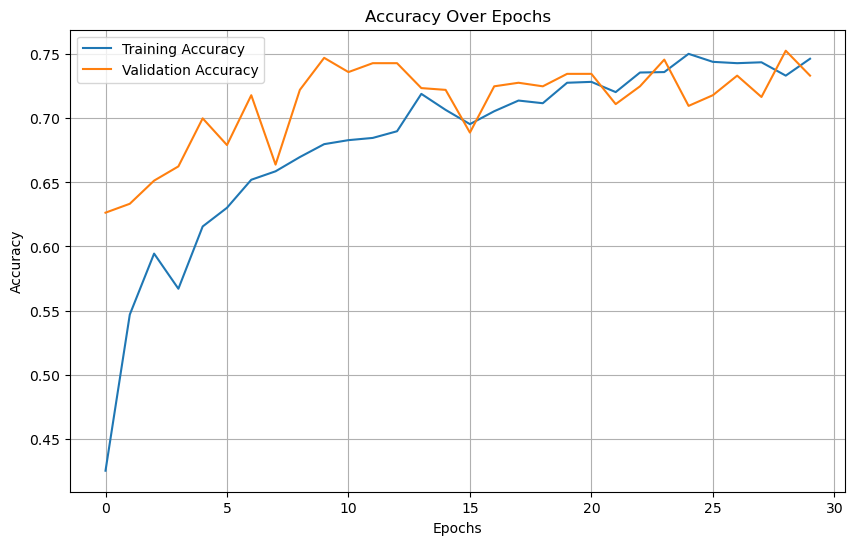

Final Training Accuracy: 0.7465
Final Validation Accuracy: 0.7333
Final Test Accuracy: 0.7538


<Figure size 1200x1200 with 0 Axes>

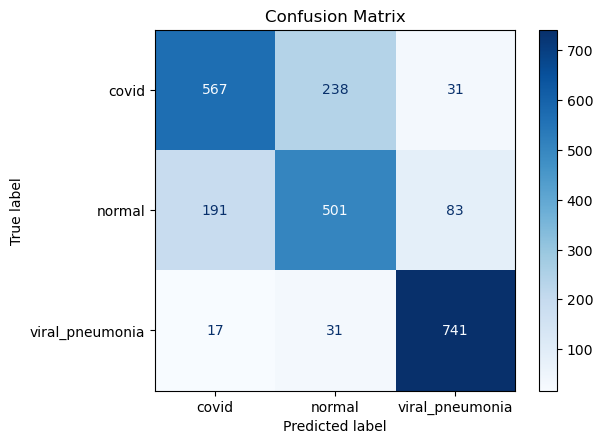

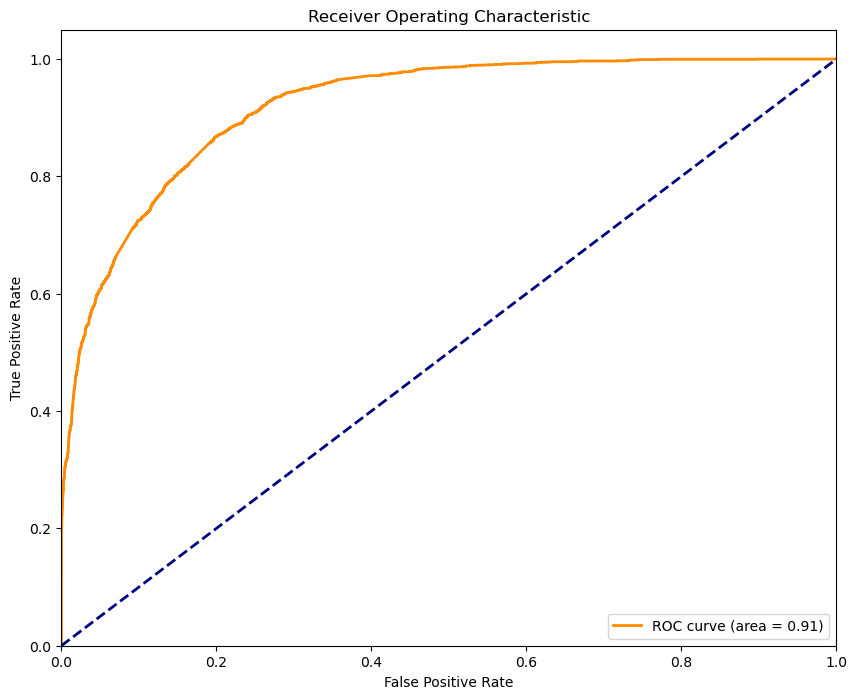

Classification Report:
                  precision    recall  f1-score   support

          covid       0.73      0.68      0.70       836
         normal       0.65      0.65      0.65       775
viral_pneumonia       0.87      0.94      0.90       789

       accuracy                           0.75      2400
      macro avg       0.75      0.75      0.75      2400
   weighted avg       0.75      0.75      0.75      2400

New model created and saved successfully.
Training history saved successfully.


In [273]:
if use_saved_model:
    try:
        # Attempt to load the saved model
        model = load_model('Models/baseline.h5')
        print("Model loaded successfully.")

        # Load the history from the pickle file
        with open('History/Baseline_history.pkl', 'rb') as file:
            history = pickle.load(file)
        
        metrics(model, X_test, y_test, label_encoder, history, model_name="Baseline")
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        use_saved_model = False
    except Exception as e:
        print(f"An error occurred: {e}")
        use_saved_model = False


if not use_saved_model:
    # Define the new model
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')  # Number of classes
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  # For integer labels
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # Generate metrics and save the model
    metrics(model, X_test, y_test, label_encoder, history.history, model_name="Baseline")  # Pass history.history instead
    model.save('Models/baseline.h5')
    print("New model created and saved successfully.")
    
    # Save the history to a pickle file
    with open('History/Baseline_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)  # Save history.history
    print("Training history saved successfully.")

# ReduceLROnPlateau
- Same structure as baseline
- Reduces learning rate after validation loss plateau
- Helps slightly

In [274]:
use_saved_model = True

Epoch 1/60
180/180 [==============================] - 2s 10ms/step - loss: 3.2399 - accuracy: 0.4521 - val_loss: 0.8196 - val_accuracy: 0.6333
Epoch 2/60
180/180 [==============================] - 1s 7ms/step - loss: 0.9600 - accuracy: 0.5576 - val_loss: 0.8098 - val_accuracy: 0.5944
Epoch 3/60
180/180 [==============================] - 1s 7ms/step - loss: 0.8853 - accuracy: 0.5597 - val_loss: 0.7540 - val_accuracy: 0.6389
Epoch 4/60
180/180 [==============================] - 1s 7ms/step - loss: 0.8691 - accuracy: 0.5847 - val_loss: 0.7379 - val_accuracy: 0.6222
Epoch 5/60
180/180 [==============================] - 1s 7ms/step - loss: 0.8094 - accuracy: 0.6073 - val_loss: 0.6791 - val_accuracy: 0.6333
Epoch 6/60
180/180 [==============================] - 1s 7ms/step - loss: 0.7713 - accuracy: 0.6215 - val_loss: 0.6721 - val_accuracy: 0.6611
Epoch 7/60
180/180 [==============================] - 1s 7ms/step - loss: 0.7519 - accuracy: 0.6295 - val_loss: 0.6584 - val_accuracy: 0.6875
Epoch

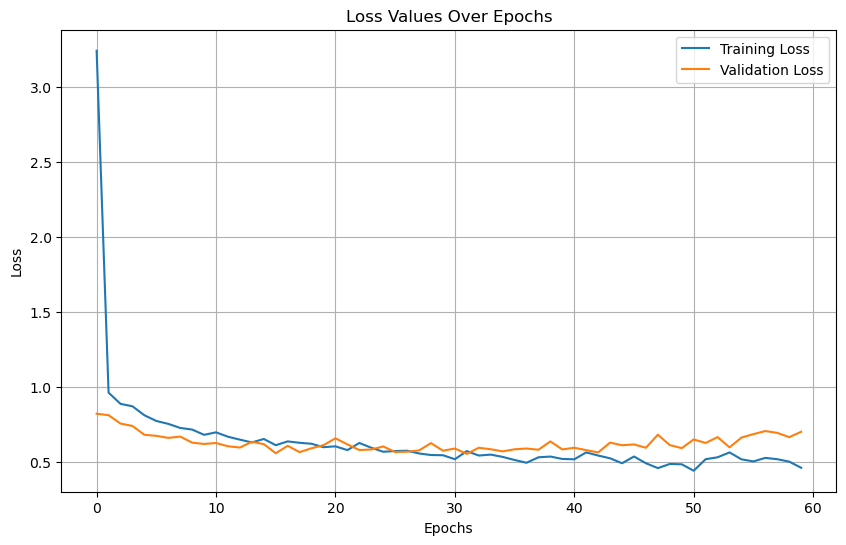

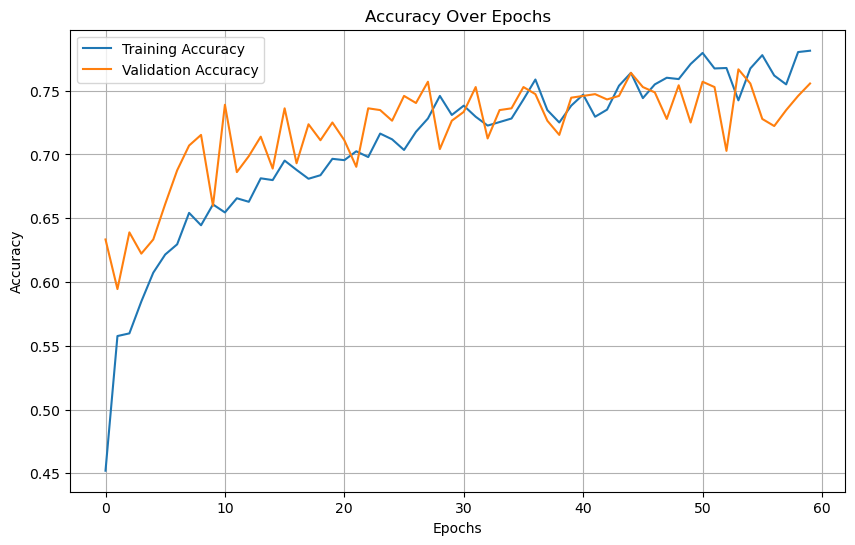

Final Training Accuracy: 0.7812
Final Validation Accuracy: 0.7556
Final Test Accuracy: 0.7608


<Figure size 1200x1200 with 0 Axes>

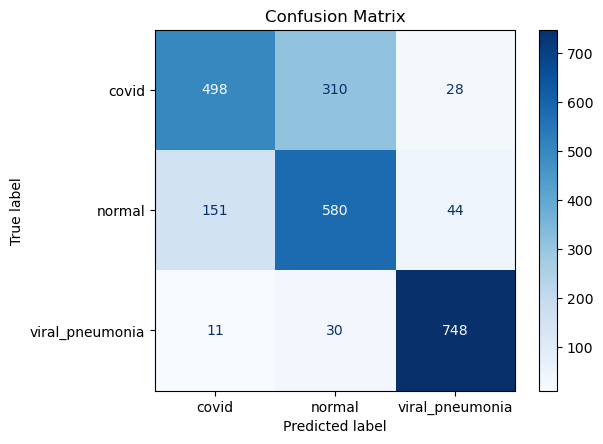

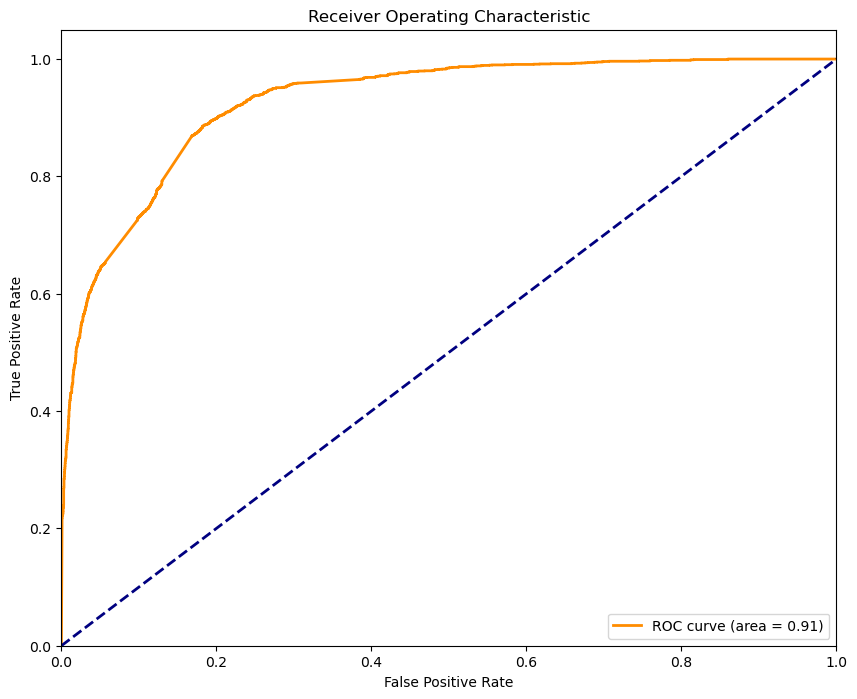

Classification Report:
                  precision    recall  f1-score   support

          covid       0.75      0.60      0.67       836
         normal       0.63      0.75      0.68       775
viral_pneumonia       0.91      0.95      0.93       789

       accuracy                           0.76      2400
      macro avg       0.77      0.76      0.76      2400
   weighted avg       0.77      0.76      0.76      2400

New model created and saved successfully.
Training history saved successfully.


In [275]:

if use_saved_model:
    try:
        # Attempt to load the saved model
        model = load_model('Models/baseline.h5')
        print("Model loaded successfully.")

        # Load the history from the pickle file
        with open('History/Baseline_history.pkl', 'rb') as file:
            history = pickle.load(file)
        
        metrics(model, X_test, y_test, label_encoder, history, model_name="Reduce_LR")
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        use_saved_model = False
    except Exception as e:
        print(f"An error occurred: {e}")
        use_saved_model = False

if not use_saved_model:
    # Define the new model
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')  # Number of classes
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  # For integer labels
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=60, batch_size=16, validation_split=0.2)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # Generate metrics and save the model
    metrics(model, X_test, y_test, label_encoder, history.history, model_name="ReduceLR")  # Pass history.history instead
    model.save('Models/baseline.h5')
    print("New model created and saved successfully.")
    
    # Save the history to a pickle file
    with open('History/Baseline_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)  # Save history.history
    print("Training history saved successfully.")

# Sequential_CNN

In [276]:
use_saved_model = True

In [277]:
X_train = X_train.reshape(-1, 256, 256, 1)
X_test = X_test.reshape(-1, 256, 256, 1)

Model loaded successfully.
75/75 [==============================] - 1s 12ms/step


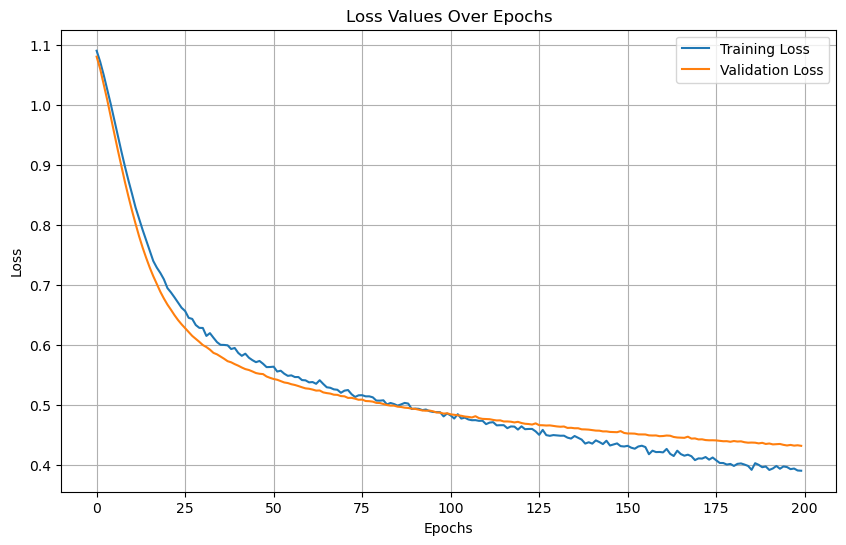

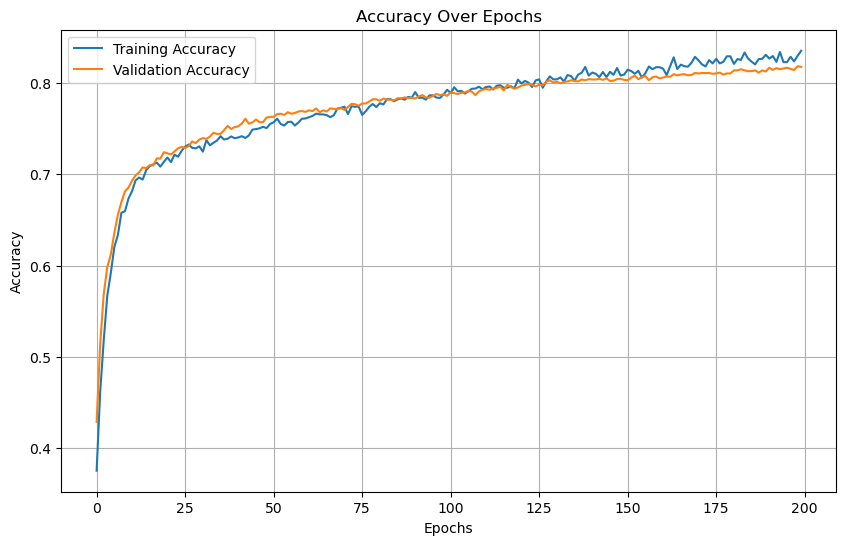

Final Training Accuracy: 0.8353
Final Validation Accuracy: 0.8175
Final Test Accuracy: 0.8175


<Figure size 1200x1200 with 0 Axes>

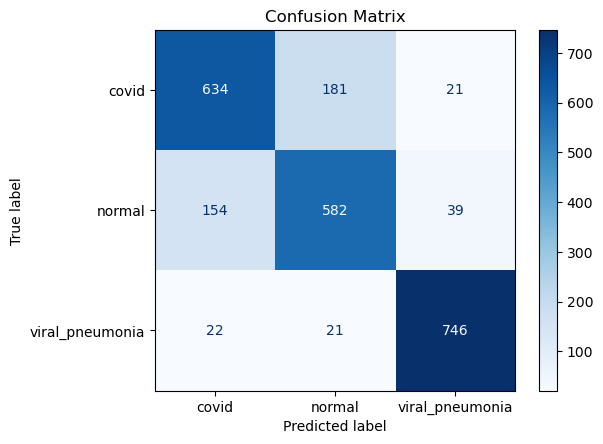

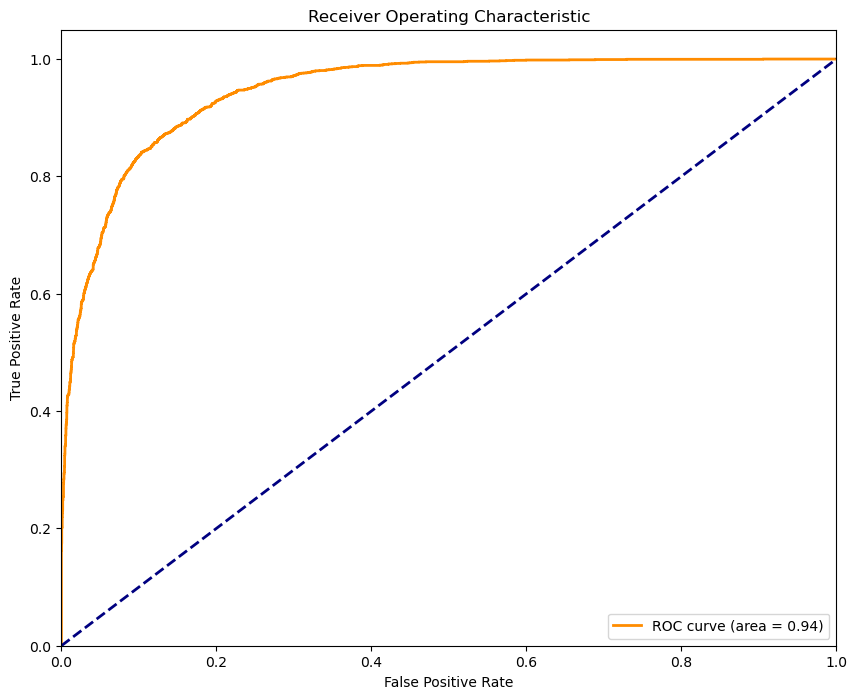

Classification Report:
                  precision    recall  f1-score   support

          covid       0.78      0.76      0.77       836
         normal       0.74      0.75      0.75       775
viral_pneumonia       0.93      0.95      0.94       789

       accuracy                           0.82      2400
      macro avg       0.82      0.82      0.82      2400
   weighted avg       0.82      0.82      0.82      2400



In [278]:

if use_saved_model:
    try:
        # Attempt to load the saved model
        model = load_model('Models/Sequential_CNN.h5')
        print("Model loaded successfully.")

        # Load the history from the pickle file
        with open('History/Sequential_CNN_history.pkl', 'rb') as file:
            history = pickle.load(file)
        
        metrics(model, X_test, y_test, label_encoder, history, model_name="Sequential")
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        use_saved_model = False
    except Exception as e:
        print(f"An error occurred: {e}")
        use_saved_model = False

if not use_saved_model:
    # Define the Sequential_CNN model
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(256, 256, 1), name='conv2d_1'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d_2'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d_3'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.3),
        Dense(units=64, activation='relu'),
        Dense(units=3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-7),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200)
    
    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # metrics(model, X_test, y_test, label_encoder, history.history)  # Pass history.history instead
    model.save('Models/Sequential_CNN.h5')
    print("New model created and saved successfully.")
    
    # Save the history to a pickle file
    with open('History/Sequential_CNN_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)  # Save history.history
    print("Training history saved successfully.")
    metrics(model, X_test, y_test, label_encoder, history.history, model_name="Sequential")


# Sequential CNN + DataGen

In [279]:
use_saved_model = True

Model loaded successfully.
75/75 [==============================] - 1s 12ms/step


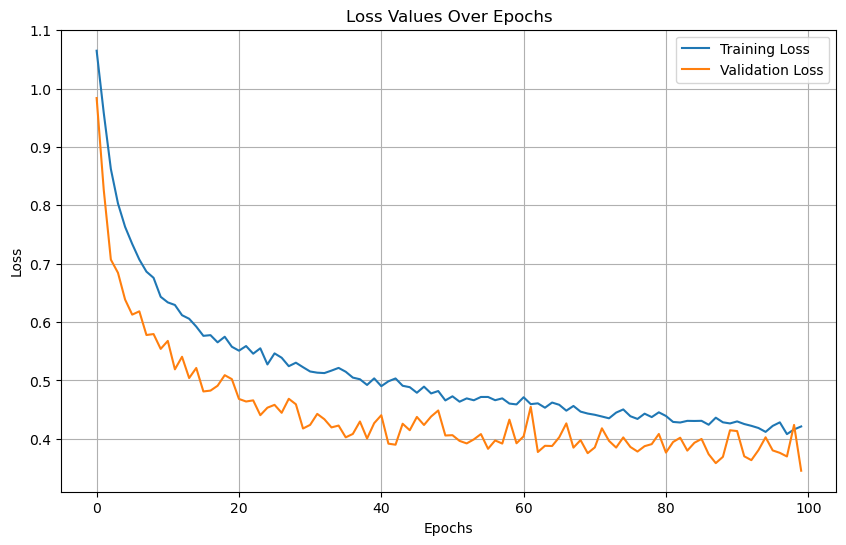

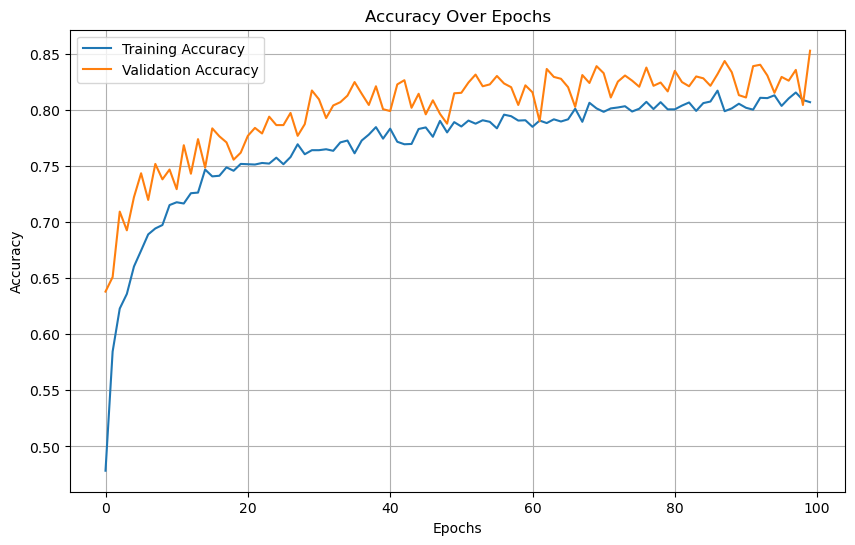

Final Training Accuracy: 0.8067
Final Validation Accuracy: 0.8525
Final Test Accuracy: 0.8525


<Figure size 1200x1200 with 0 Axes>

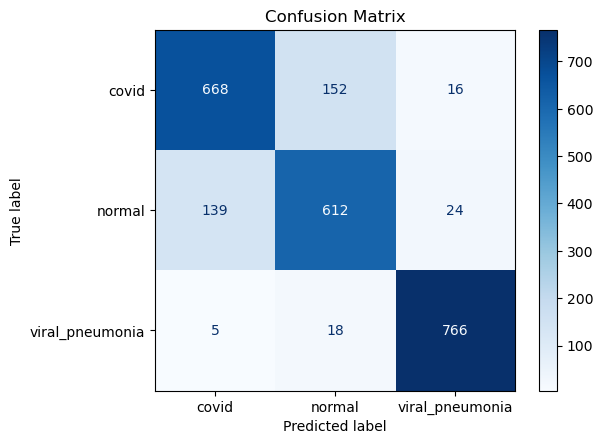

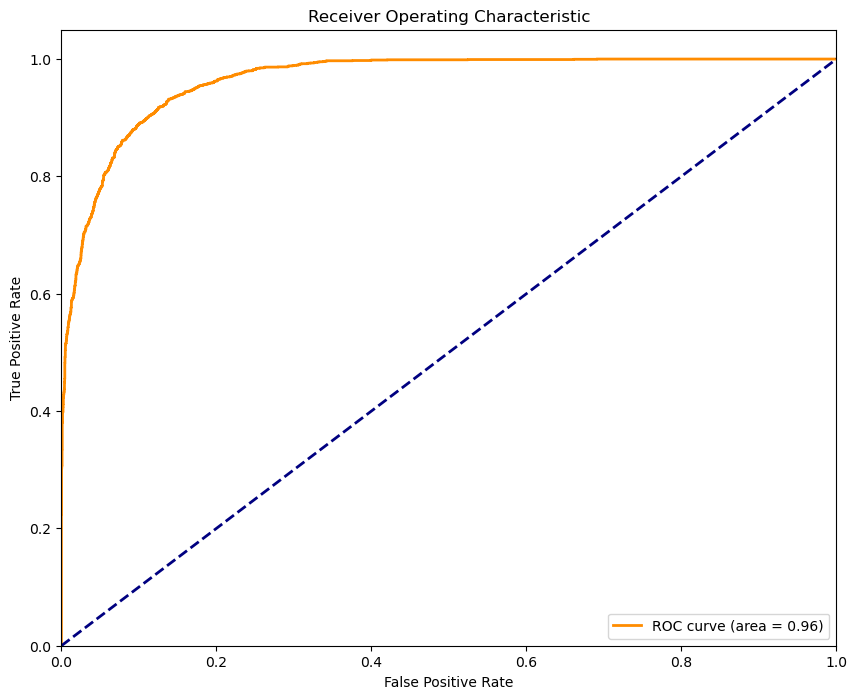

Classification Report:
                  precision    recall  f1-score   support

          covid       0.82      0.80      0.81       836
         normal       0.78      0.79      0.79       775
viral_pneumonia       0.95      0.97      0.96       789

       accuracy                           0.85      2400
      macro avg       0.85      0.85      0.85      2400
   weighted avg       0.85      0.85      0.85      2400



In [280]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

if use_saved_model:
    try:
        # Attempt to load the saved model
        model = load_model('Models/Sequential_CNN+DataGen.h5')
        print("Model loaded successfully.")

        # Load the history from the pickle file
        with open('History/Sequential_CNN+DataGen_history.pkl', 'rb') as file:
            history = pickle.load(file)
        
        metrics(model, X_test, y_test, label_encoder, history, model_name="Sequential_CNN_Datagen")
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        use_saved_model = False
    except Exception as e:
        print(f"An error occurred: {e}")
        use_saved_model = False

if not use_saved_model:
    
    datagen = ImageDataGenerator(
        rotation_range=10,          # Rotate images up to 20 degrees
        width_shift_range=0.05,      # Shift images horizontally by 20% of the width
        height_shift_range=0.05,     # Shift images vertically by 20% of the height
        shear_range=0.05,           # Shear the image by 15%
        zoom_range=0.05,            # Zoom into the image by 15%
        horizontal_flip=True,       # Flip images horizontally
        fill_mode='nearest'         # Fill missing pixels with the nearest available
    )
    
    # Fit the datagen on your training data
    datagen.fit(X_train)
    
    # Define your model
    model = Sequential()
    
    # Convolutional Layer 1
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
    
    # MaxPooling Layer 1
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Convolutional Layer 2
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    
    # MaxPooling Layer 2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Convolutional Layer 3
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    
    # MaxPooling Layer 3
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Flatten the layers
    model.add(Flatten())
    
    # Fully connected layer 1
    model.add(Dense(units=128, activation='relu'))
    
    # Dropout for regularization
    model.add(Dropout(0.3))
    
    # Fully connected layer 2
    model.add(Dense(units=64, activation='relu'))
    
    # Output Layer
    model.add(Dense(units=3, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model with data augmentation
    history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                        validation_data=(X_test, y_test),
                        epochs=100)
    
    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    metrics(model, X_test, y_test, label_encoder, history.history) 
    model.save('Models/Sequential_CNN+DataGen.h5')
    print("New model created and saved successfully.")
    
    # Save the history to a pickle file
    with open('History/Sequential_CNN+DataGen_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)  # Save history.history
    print("Training history saved successfully.")
    metrics(model, X_test, y_test, label_encoder, history.history, model_name="Sequential_CNN_Datagen")

# Sequential CNN + DataGen + Optimal

In [281]:
use_saved_model = True

Model loaded successfully.
75/75 [==============================] - 1s 9ms/step


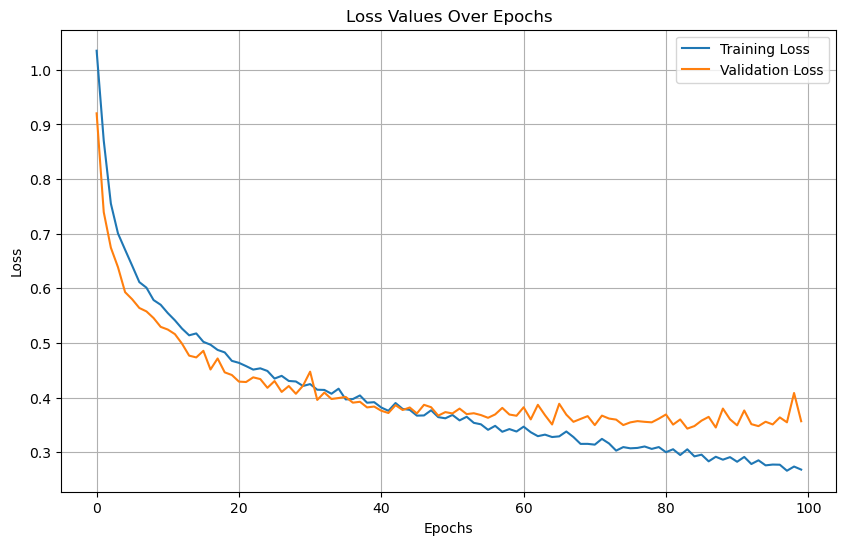

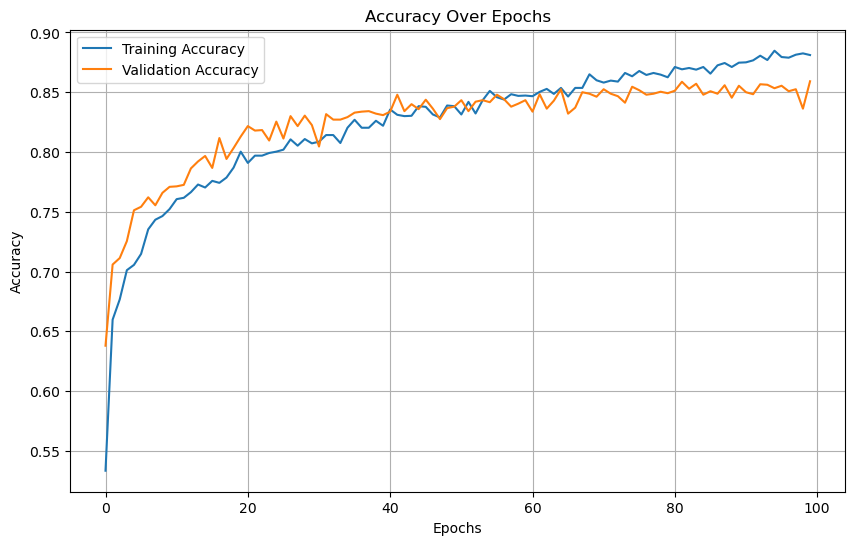

Final Training Accuracy: 0.8811
Final Validation Accuracy: 0.8592
Final Test Accuracy: 0.8592


<Figure size 1200x1200 with 0 Axes>

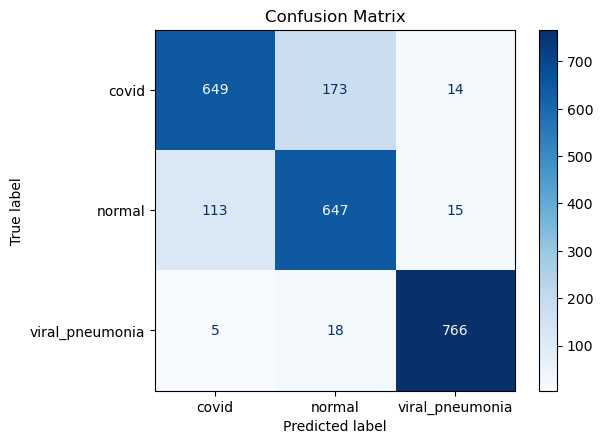

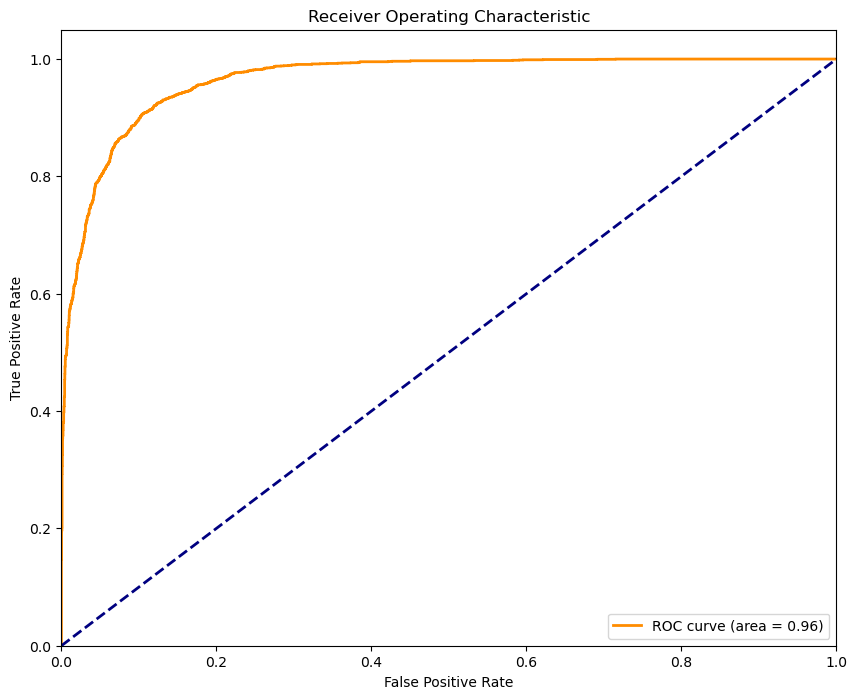

Classification Report:
                  precision    recall  f1-score   support

          covid       0.85      0.78      0.81       836
         normal       0.77      0.83      0.80       775
viral_pneumonia       0.96      0.97      0.97       789

       accuracy                           0.86      2400
      macro avg       0.86      0.86      0.86      2400
   weighted avg       0.86      0.86      0.86      2400



In [282]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

if use_saved_model:
    try:
        # Attempt to load the saved model
        model = load_model('Models/Sequential_CNN+DataGen+Optimal.h5')
        print("Model loaded successfully.")

        # Load the history from the pickle file
        with open('History/Sequential_CNN+DataGen+Optimal_history.pkl', 'rb') as file:
            history = pickle.load(file)
        
        metrics(model, X_test, y_test, label_encoder, history, model_name="Sequential_CNN_Datagen_Optimal")
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        use_saved_model = False
    except Exception as e:
        print(f"An error occurred: {e}")
        use_saved_model = False

if not use_saved_model:
    
    datagen = ImageDataGenerator(
        rotation_range=5,          # Rotate images up to 20 degrees
        width_shift_range=0.01,      # Shift images horizontally by 20% of the width
        height_shift_range=0.01,     # Shift images vertically by 20% of the height
        shear_range=0.01,           # Shear the image by 15%
        zoom_range=0.01,            # Zoom into the image by 15%
        horizontal_flip=True,       # Flip images horizontally
        fill_mode='nearest'         # Fill missing pixels with the nearest available
    )

    
    # Fit the datagen on your training data
    datagen.fit(X_train)
    
    # Define your model
    model = Sequential()
    
    # Convolutional Layer 1
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
    
    # MaxPooling Layer 1
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Convolutional Layer 2
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    
    # MaxPooling Layer 2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Convolutional Layer 3
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    
    # MaxPooling Layer 3
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Flatten the layers
    model.add(Flatten())
    
    # Fully connected layer 1
    model.add(Dense(units=128, activation='relu'))
    
    # Dropout for regularization
    model.add(Dropout(0.3))
    
    # Fully connected layer 2
    model.add(Dense(units=64, activation='relu'))
    
    # Output Layer
    model.add(Dense(units=3, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model with data augmentation
    history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                        validation_data=(X_test, y_test),
                        epochs=100)
    
    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    model.save('Models/Sequential_CNN+DataGen+Optimal.h5')
    print("New model created and saved successfully.")
    
    # Save the history to a pickle file
    with open('History/Sequential_CNN+DataGen+Optimal_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)  # Save history.history
    print("Training history saved successfully.")
    metrics(model, X_test, y_test, label_encoder, history.history, model_name="Sequential_CNN_Datagen_Optimal")

In [283]:
use_saved_model = True

Model loaded successfully.
75/75 [==============================] - 1s 12ms/step


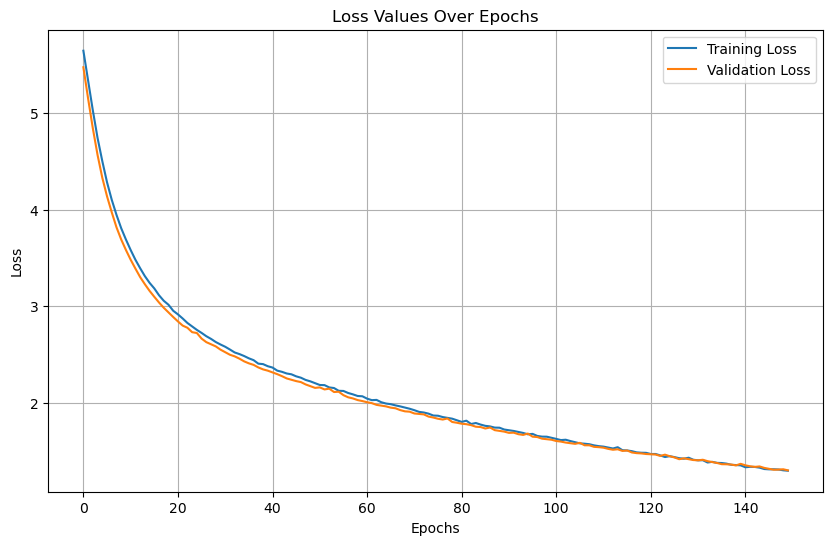

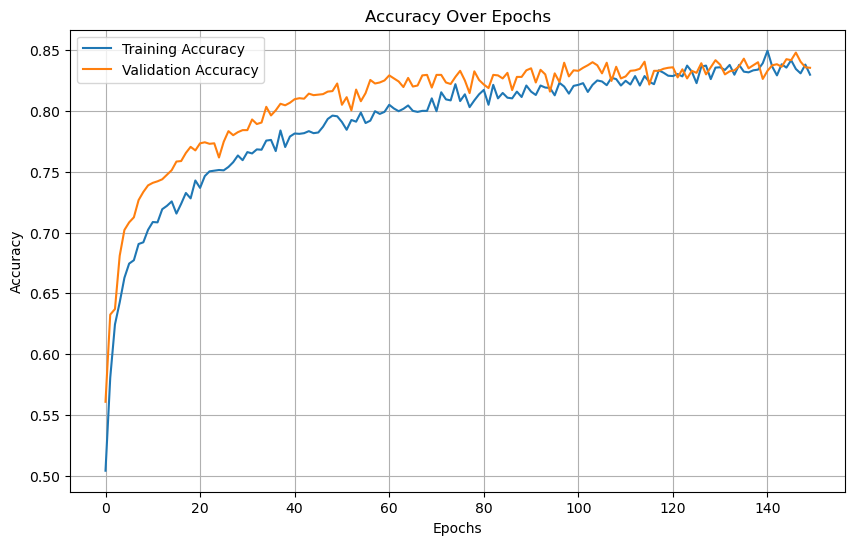

Final Training Accuracy: 0.8297
Final Validation Accuracy: 0.8354
Final Test Accuracy: 0.8354


<Figure size 1200x1200 with 0 Axes>

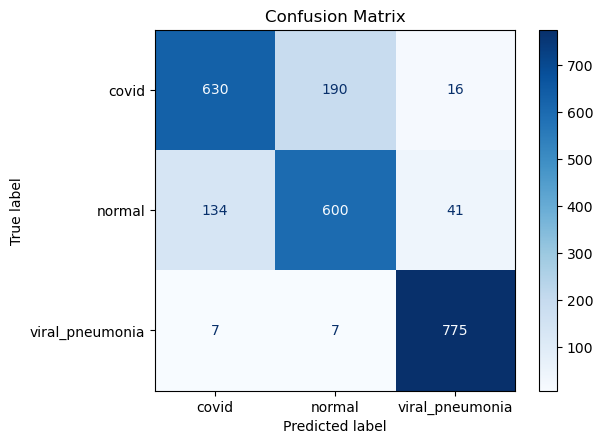

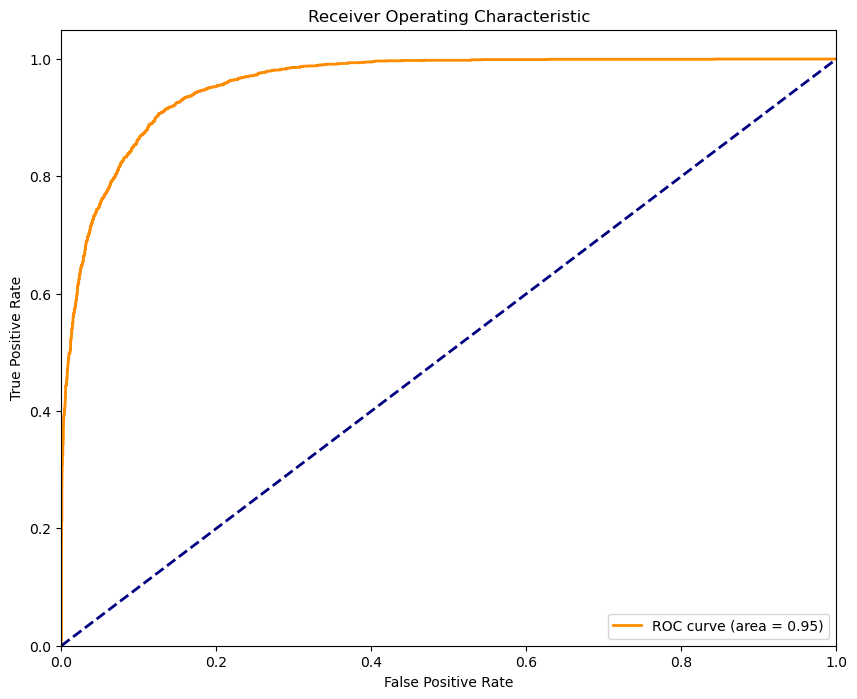

Classification Report:
                  precision    recall  f1-score   support

          covid       0.82      0.75      0.78       836
         normal       0.75      0.77      0.76       775
viral_pneumonia       0.93      0.98      0.96       789

       accuracy                           0.84      2400
      macro avg       0.83      0.84      0.83      2400
   weighted avg       0.83      0.84      0.83      2400



In [284]:
from tensorflow.keras import regularizers

if use_saved_model:
    try:
        # Attempt to load the saved model
        model = load_model('Models/Sequential_CNN+DataGen+Optimal+L2.h5')
        print("Model loaded successfully.")

        # Load the history from the pickle file
        with open('History/Sequential_CNN+DataGen+Optimal+L2_history.pkl', 'rb') as file:
            history = pickle.load(file)
        
        metrics(model, X_test, y_test, label_encoder, history, model_name="Sequential_CNN_Datagen_Optimal_L2")
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        use_saved_model = False
    except Exception as e:
        print(f"An error occurred: {e}")
        use_saved_model = False

if not use_saved_model:
    
    datagen = ImageDataGenerator(
        rotation_range=5,          # Rotate images up to 20 degrees
        width_shift_range=0.01,      # Shift images horizontally by 10% of the width
        height_shift_range=0.01,     # Shift images vertically by 10% of the height
        shear_range=0.01,            # Shear the image by 10%
        zoom_range=0.01,             # Zoom into the image by 10%
        horizontal_flip=True,       # Flip images horizontally
        fill_mode='nearest'         # Fill missing pixels with the nearest available
    )

    # Fit the datagen on your training data
    datagen.fit(X_train)
    
    # Define your model
    model = Sequential()
    
    # Convolutional Layer 1 with L2 regularization
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.01), input_shape=(256, 256, 1)))
    
    # MaxPooling Layer 1
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Convolutional Layer 2 with L2 regularization
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.01)))
    
    # MaxPooling Layer 2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Convolutional Layer 3 with L2 regularization
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.01)))
    
    # MaxPooling Layer 3
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Flatten the layers
    model.add(Flatten())
    
    # Fully connected layer 1 with L2 regularization
    model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    
    # Dropout for regularization
    model.add(Dropout(0.3))
    
    # Fully connected layer 2 with L2 regularization
    model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    
    # Output Layer
    model.add(Dense(units=3, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model with data augmentation
    history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                        validation_data=(X_test, y_test),
                        epochs=150)
    
    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    model.save('Models/Sequential_CNN+DataGen+Optimal+L2.h5')
    print("New model created and saved successfully.")
    
    # Save the history to a pickle file
    with open('History/Sequential_CNN+DataGen+Optimal+L2_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)  # Save history.history
    print("Training history saved successfully.")
    metrics(model, X_test, y_test, label_encoder, history.history, model_name="Sequential_CNN_Datagen_Optimal_L2")